In [2]:
import pandas as pd

# Because your notebook is inside the "data" folder,
# the CSV file is in the same folder, so we read it directly.
df = pd.read_csv("netflix_titles.csv")

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:\n")
print(df.head(5))

Dataset shape: (8807, 12)

Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

First 5 rows:

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

        

In [3]:
import pandas as pd
import numpy as np

# 1) Start from the original df
movies = df[df["type"].str.lower() == "movie"].copy()

# 2) Convert duration to minutes (only for movies)
movies["duration_minutes"] = (
    movies["duration"].astype(str).str.replace(" min", "", regex=False).str.strip()
)
movies["duration_minutes"] = pd.to_numeric(movies["duration_minutes"], errors="coerce")

# 3) Make sure release_year is numeric
movies["release_year"] = pd.to_numeric(movies["release_year"], errors="coerce")

# 4) Fill missing rating
movies["rating"] = movies["rating"].fillna("Unknown")

# 5) Keep only rows with duration_minutes and release_year
movies_clean = movies.dropna(subset=["duration_minutes", "release_year"]).copy()

print("Movies only shape (clean):", movies_clean.shape)
print("Duration minutes summary:")
print(movies_clean["duration_minutes"].describe())


Movies only shape (clean): (6128, 13)
Duration minutes summary:
count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_minutes, dtype: float64


In [4]:
# Step 5: Outlier removal using IQR for duration_minutes

q1 = movies_clean["duration_minutes"].quantile(0.25)
q3 = movies_clean["duration_minutes"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

movies_no_outliers = movies_clean[
    (movies_clean["duration_minutes"] >= lower) &
    (movies_clean["duration_minutes"] <= upper)
].copy()

print("Outlier bounds (minutes):", lower, "to", upper)
print("Movies shape after outlier removal:", movies_no_outliers.shape)
print("\nDuration summary after outlier removal:")
print(movies_no_outliers["duration_minutes"].describe())


Outlier bounds (minutes): 46.5 to 154.5
Movies shape after outlier removal: (5678, 13)

Duration summary after outlier removal:
count    5678.000000
mean       99.962487
std        21.094071
min        47.000000
25%        88.000000
50%        98.500000
75%       113.000000
max       154.000000
Name: duration_minutes, dtype: float64


In [5]:
import numpy as np

def descriptive_stats(sample_df, field):
    s = sample_df[field].dropna()
    return {
        "count": int(s.count()),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "mode": float(s.mode().iloc[0]) if not s.mode().empty else np.nan,
        "min": float(s.min()),
        "max": float(s.max()),
        "std": float(s.std(ddof=1)),
        "var": float(s.var(ddof=1)),
        "q1": float(s.quantile(0.25)),
        "q3": float(s.quantile(0.75)),
        "iqr": float(s.quantile(0.75) - s.quantile(0.25))
    }

full_desc = descriptive_stats(movies_no_outliers, "duration_minutes")
print("Full dataset descriptive stats (duration_minutes):")
print(full_desc)


Full dataset descriptive stats (duration_minutes):
{'count': 5678, 'mean': 99.96248679112364, 'median': 98.5, 'mode': 90.0, 'min': 47.0, 'max': 154.0, 'std': 21.09407119663833, 'var': 444.95983964884675, 'q1': 88.0, 'q3': 113.0, 'iqr': 25.0}


In [6]:
random_sample = movies_no_outliers.sample(n=150, random_state=42)
random_desc = descriptive_stats(random_sample, "duration_minutes")

print("Random sample (n=150) descriptive stats (duration_minutes):")
print(random_desc)

Random sample (n=150) descriptive stats (duration_minutes):
{'count': 150, 'mean': 102.04, 'median': 100.0, 'mode': 99.0, 'min': 53.0, 'max': 153.0, 'std': 20.398670834446065, 'var': 416.1057718120805, 'q1': 91.25, 'q3': 114.0, 'iqr': 22.75}


In [7]:
sorted_df = movies_no_outliers.sort_values("release_year").reset_index(drop=True)

k = max(1, len(sorted_df) // 150)   # step size
systematic_sample = sorted_df.iloc[::k].head(150).copy()

systematic_desc = descriptive_stats(systematic_sample, "duration_minutes")

print("Systematic sample (n=150) descriptive stats (duration_minutes):")
print(systematic_desc)
print("Systematic sampling step k:", k)


Systematic sample (n=150) descriptive stats (duration_minutes):
{'count': 150, 'mean': 100.86666666666666, 'median': 98.0, 'mode': 88.0, 'min': 52.0, 'max': 151.0, 'std': 22.258899635323207, 'var': 495.4586129753916, 'q1': 88.0, 'q3': 115.0, 'iqr': 27.0}
Systematic sampling step k: 37


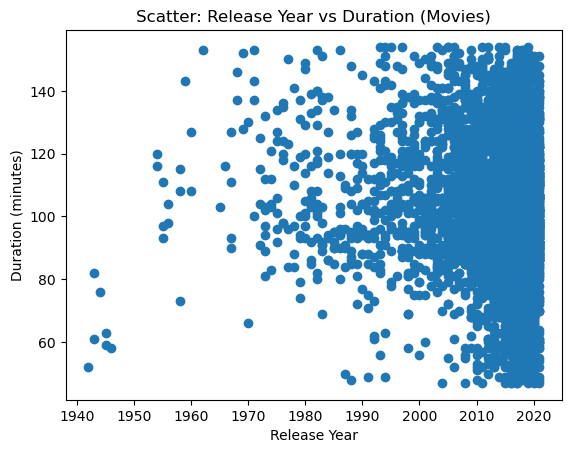

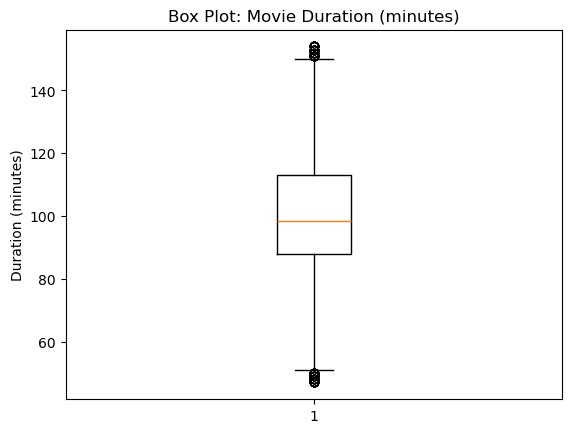

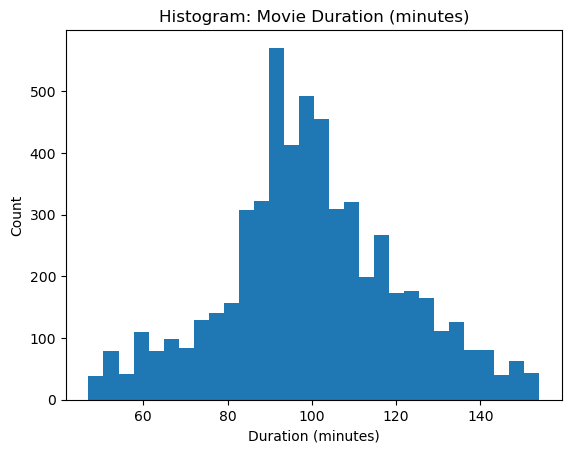

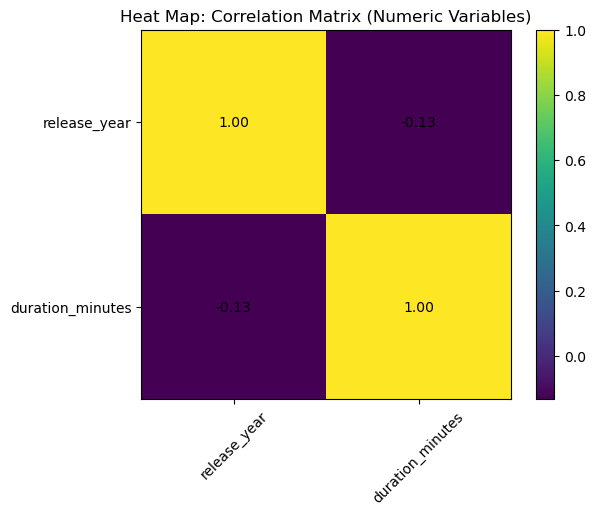

Saved charts in: figures/
['boxplot_duration.png', 'heatmap_correlation.png', 'hist_duration.png', 'scatter_releaseyear_duration.png']


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure figures folder exists
import os
os.makedirs("figures", exist_ok=True)

# A) Scatter plot: release_year vs duration_minutes
plt.figure()
plt.scatter(movies_no_outliers["release_year"], movies_no_outliers["duration_minutes"])
plt.title("Scatter: Release Year vs Duration (Movies)")
plt.xlabel("Release Year")
plt.ylabel("Duration (minutes)")
plt.savefig("figures/scatter_releaseyear_duration.png", bbox_inches="tight")
plt.show()

# B) Box plot: duration_minutes
plt.figure()
plt.boxplot(movies_no_outliers["duration_minutes"].dropna(), vert=True)
plt.title("Box Plot: Movie Duration (minutes)")
plt.ylabel("Duration (minutes)")
plt.savefig("figures/boxplot_duration.png", bbox_inches="tight")
plt.show()

# C) Histogram: duration_minutes
plt.figure()
plt.hist(movies_no_outliers["duration_minutes"].dropna(), bins=30)
plt.title("Histogram: Movie Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.savefig("figures/hist_duration.png", bbox_inches="tight")
plt.show()

# D) Heat map: correlation matrix for numeric variables
corr_df = movies_no_outliers[["release_year", "duration_minutes"]].corr()

plt.figure()
plt.imshow(corr_df.values)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45)
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title("Heat Map: Correlation Matrix (Numeric Variables)")

for (i, j), val in np.ndenumerate(corr_df.values):
    plt.text(j, i, f"{val:.2f}", ha="center", va="center")

plt.colorbar()
plt.savefig("figures/heatmap_correlation.png", bbox_inches="tight")
plt.show()

print("Saved charts in: figures/")
print(os.listdir("figures"))


In [9]:
from scipy import stats
from scipy.stats import chi2_contingency
import pandas as pd

# Pearson + Spearman (numeric vs numeric)
x = movies_no_outliers["release_year"]
y = movies_no_outliers["duration_minutes"]

pearson_r, pearson_p = stats.pearsonr(x, y)
spearman_r, spearman_p = stats.spearmanr(x, y)

print("Pearson (release_year vs duration_minutes):")
print("r =", pearson_r, "p-value =", pearson_p)

print("\nSpearman (release_year vs duration_minutes):")
print("rho =", spearman_r, "p-value =", spearman_p)

# Chi-square (categorical vs categorical)
# Make duration into buckets so it becomes categorical
movies_no_outliers["duration_bucket"] = pd.cut(
    movies_no_outliers["duration_minutes"],
    bins=[0, 80, 100, 120, 1000],
    labels=["Short", "Medium", "Long", "Very Long"]
)

cont_table = pd.crosstab(movies_no_outliers["rating"], movies_no_outliers["duration_bucket"])
chi2, chi_p, dof, expected = chi2_contingency(cont_table)

print("\nChi-square (rating vs duration_bucket):")
print("chi2 =", chi2, "p-value =", chi_p, "dof =", dof)


Pearson (release_year vs duration_minutes):
r = -0.13330457450903926 p-value = 6.2637403008528126e-24

Spearman (release_year vs duration_minutes):
rho = -0.13582157340560252 p-value = 8.680821935181385e-25

Chi-square (rating vs duration_bucket):
chi2 = 1038.754196538177 p-value = 2.387497803915138e-190 dof = 42


In [10]:
from scipy import stats

population_mean = movies_no_outliers["duration_minutes"].mean()

t_stat, t_p = stats.ttest_1samp(random_sample["duration_minutes"], popmean=population_mean)

print("Population mean duration (minutes):", population_mean)
print("One-sample t-test (random sample vs population mean):")
print("t-stat =", t_stat, "p-value =", t_p)


Population mean duration (minutes): 99.96248679112364
One-sample t-test (random sample vs population mean):
t-stat = 1.2473477651901677 p-value = 0.21422698484564398


In [11]:
print("Movies only shape (clean):", movies_clean.shape)
print(movies_clean[["duration_minutes"]].describe())


Movies only shape (clean): (6128, 13)
       duration_minutes
count       6128.000000
mean          99.577187
std           28.290593
min            3.000000
25%           87.000000
50%           98.000000
75%          114.000000
max          312.000000
